# Training vs validation loss

Diabetes regression

We need to track generality and prevent overfitting. Deep learning models are extremely flexible and can often get the training error down to zero.

## Support code

In [1]:
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

In [2]:
def plot_history(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='upper right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")

In [3]:
d = load_diabetes()
len(d.data)

442

In [4]:
df = pd.DataFrame(d.data, columns=d.feature_names)
df['disease'] = d.target # "quantitative measure of disease progression one year after baseline"
df.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0


## Split data into train, validation sets

We'll use "test" as shorthand for "validation" but technically they are not the same.

In [5]:
n = len(df)
n_test = int(n*0.20) # 20% held out as validation set
n_train = n - n_test
df = df.sample(frac=1) # shuffle data
X = df.drop('disease',axis=1).values
y = df['disease'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test)

In [6]:
m = np.mean(X_train,axis=0)
std = np.std(X_train,axis=0)
X_train = (X_train-m)/std
X_test = (X_test-m)/std       # use training data only when prepping test sets

## Baseline with random forest

In [7]:
rf = RandomForestRegressor(n_estimators=500)#, min_samples_leaf=2, max_features=1)
rf.fit(X_train, y_train.reshape(-1))
y_pred = rf.predict(X_train)
mse = np.mean((y_pred - y_train.reshape(-1))**2)

y_pred = rf.predict(X_test)
mse_test = np.mean((y_pred - y_test.reshape(-1))**2)

print(f"Training MSE {mse:.2f} validation MSE {mse_test:.2f}")

Training MSE 430.83 validation MSE 4157.25


In [8]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float().reshape(-1,1) # column vector
y_test = torch.tensor(y_test).float().reshape(-1,1)

## Train network with increasingly sophisticated train method

### Most basic network training; just track training loss

In [9]:
def train0(model, X_train, X_test, y_train, y_test,
          learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()

In [10]:
ncols = X.shape[1]
n_neurons = 100
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

train0(model, X_train, X_test, y_train, y_test,
       learning_rate=.1, nepochs=1000)

Epoch    0 MSE train loss    28200.963
Epoch  100 MSE train loss     2281.749
Epoch  200 MSE train loss     1764.779
Epoch  300 MSE train loss     1112.935
Epoch  400 MSE train loss      776.666
Epoch  500 MSE train loss      573.892
Epoch  600 MSE train loss      461.805
Epoch  700 MSE train loss      351.697
Epoch  800 MSE train loss      328.818
Epoch  900 MSE train loss      271.940
Epoch 1000 MSE train loss      229.534


### Track validation loss and compare with plot, demonstrate overfitting

In [11]:
def train1(model, X_train, X_test, y_train, y_test,
           learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = [] # track training and validation loss
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)
        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    return torch.tensor(history)

Epoch    0 MSE train loss    28323.197   test loss    32478.375
Epoch  100 MSE train loss     2296.361   test loss     3486.869
Epoch  200 MSE train loss     1874.122   test loss     3693.174
Epoch  300 MSE train loss     1186.510   test loss     4504.725
Epoch  400 MSE train loss      861.907   test loss     5421.937
Epoch  500 MSE train loss      696.835   test loss     5809.448
Epoch  600 MSE train loss      548.940   test loss     6118.016
Epoch  700 MSE train loss      478.555   test loss     6403.329
Epoch  800 MSE train loss      430.588   test loss     6720.633
Epoch  900 MSE train loss      320.291   test loss     6937.679
Epoch 1000 MSE train loss      265.206   test loss     7181.570


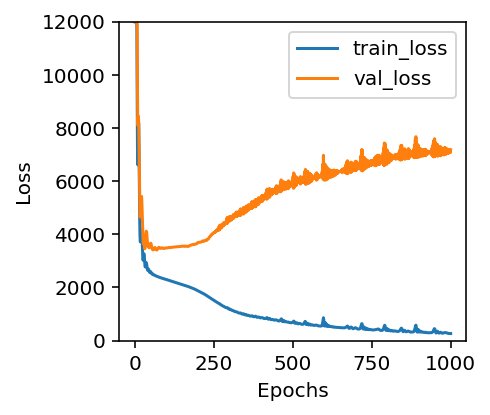

In [12]:
ncols = X.shape[1]
n_neurons = 100
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

history = train1(model, X_train, X_test, y_train, y_test,
                 learning_rate=.1, nepochs=1000)

plot_history(torch.clamp(history, 0, 12000), file="train-test")

### Use weight decay to reduce overfitting

In [13]:
def train2(model, X_train, X_test, y_train, y_test,
           learning_rate = .5, nepochs=2000, weight_decay=0, trace=True):
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, weight_decay=weight_decay)
    history = [] # track training and validation loss
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if trace and epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    return torch.tensor(history)

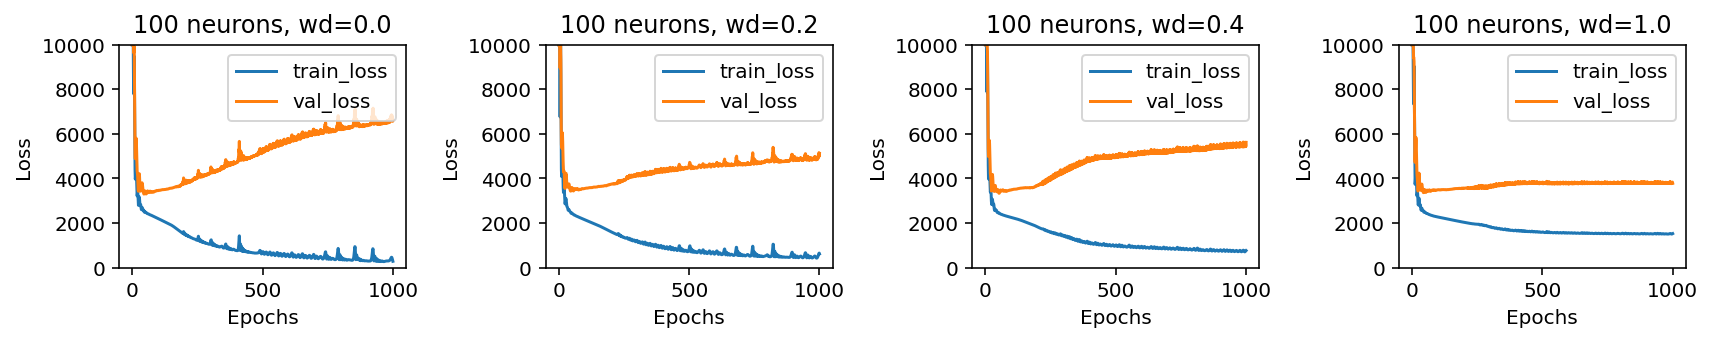

In [14]:
ncols = X.shape[1]
n_neurons = 100

fig, axes = plt.subplots(1, 4,figsize=(12,2.5))

for wd,ax in zip([0,.2,.4,1],axes):
    model = nn.Sequential(
        nn.Linear(ncols, n_neurons),
        nn.ReLU(),
        nn.Linear(n_neurons, 1)
    )
    history = train2(model, X_train, X_test, y_train, y_test,
                     learning_rate=.15, nepochs=1000, weight_decay=wd,
                     trace=False)
    ax.set_title(f"{n_neurons} neurons, wd={wd:.1f}")
    plot_history(torch.clamp(history, 0, 10000), ax=ax, maxy=10_000)

plt.tight_layout()
plt.show()

### Track best loss, model; crank up neurons and stop early

In [15]:
def train3(model, X_train, X_test, y_train, y_test,
           learning_rate = .5, nepochs=2000, weight_decay=0):
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, weight_decay=weight_decay)
    history = [] # track training and validation loss
    best_loss = 1e10
    best_model = None
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"BEST MSE test loss {best_loss:.3f}")
    return torch.tensor(history), best_model

Epoch    0 MSE train loss    28217.641   test loss    32359.250
Epoch  200 MSE train loss     8352.925   test loss    10727.639
Epoch  400 MSE train loss     3917.676   test loss     5229.231
Epoch  600 MSE train loss     3024.474   test loss     4113.047
Epoch  800 MSE train loss     2669.592   test loss     3738.824
Epoch 1000 MSE train loss     2505.675   test loss     3612.231
Epoch 1200 MSE train loss     2410.897   test loss     3564.828
Epoch 1400 MSE train loss     2345.854   test loss     3538.623
Epoch 1600 MSE train loss     2304.065   test loss     3536.032
Epoch 1800 MSE train loss     2269.534   test loss     3536.772
Epoch 2000 MSE train loss     2242.863   test loss     3534.695
BEST MSE test loss 3534.140
MSE test loss 3534.140


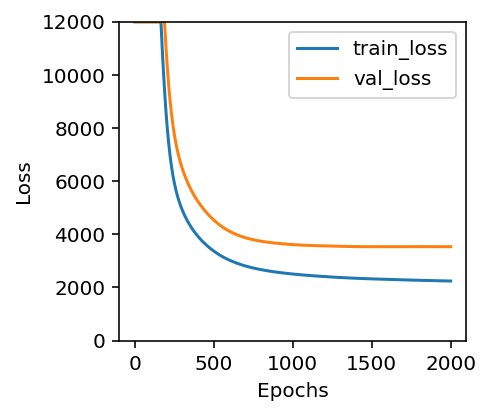

In [16]:
ncols = X.shape[1]
n_neurons = 200
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

history, best_model = train3(model, X_train, X_test, y_train, y_test,
                             learning_rate=.0015, nepochs=2000,
                             weight_decay=0)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)
print(f"MSE test loss {loss_test:.3f}")

plot_history(torch.clamp(history, 0, 12000))

## Layer activation normalization (Batch normalization)

Just as we normalize or standardize the input variables, networks train better if we normalize the output of each layer's activation. These activations are the input to the next layer. In this way we normalize the input to every layer. called batch normalization because we normally train with batches not the entire data set. But it's really just fixing the mean and variance of each layer activation to zero mean and unit variance.  This is not joint distribution. Each neuron activation "whitened" independently. Then we scale and shift using two new model parameters to support same representation as previous layer activation. At test time, we use mean/var estimated during training for activtions to whiten the activations as the test instance sails through the network.  the learned parameters scale and shift but do not change the shape of the distribution. helps move gradients through the network.

as training progresses, the input to a hidden layer changes distribution (internal covariate shift), which means that the hidden layer weights must change as well. Small changes at the first layer amplify through deep networks. As with normalizing the input layer, it is believed to support faster learning rates for faster training. It also has a regularization effect, improving model generality. The model could also be less sensitive to the initialization procedure.  See [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167) for more information.

because mean/var computed on mini-batch we get some noise, which regularizes like dropout. Andrew Ng says slight effect, not as good as dropout for regularization. More about speeding up training.

See video [Why Does Batch Norm Work?](https://www.youtube.com/watch?v=nUUqwaxLnWs)

Epoch    0 MSE train loss    28250.283   test loss    32417.945
Epoch  200 MSE train loss    12526.449   test loss    15594.207
Epoch  400 MSE train loss     2955.415   test loss     4912.444
Epoch  600 MSE train loss     2171.551   test loss     3638.722
Epoch  800 MSE train loss     2123.263   test loss     3545.691
Epoch 1000 MSE train loss     2101.116   test loss     3515.249
Epoch 1200 MSE train loss     2087.261   test loss     3506.742
Epoch 1400 MSE train loss     2076.437   test loss     3498.586
Epoch 1600 MSE train loss     2065.422   test loss     3493.304
Epoch 1800 MSE train loss     2054.293   test loss     3492.832
Epoch 2000 MSE train loss     2043.210   test loss     3500.590
BEST MSE test loss 3489.062
MSE test loss 3489.062


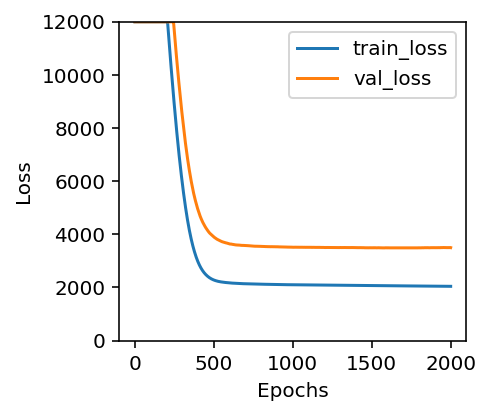

In [17]:
ncols = X.shape[1]
n_neurons = 200
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.BatchNorm1d(n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

history, best_model = train3(model, X_train, X_test, y_train, y_test,
                             learning_rate=.0015, nepochs=2000,
                             weight_decay=0)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)
print(f"MSE test loss {loss_test:.3f}")

plot_history(torch.clamp(history, 0, 12000))